In [8]:
import pandas as pd

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Models
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR



## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import shap

## Customized functions
import importlib
import utilities
importlib.reload(utilities)
from utilities import *

In [4]:
#Loading the cleaned data
df1 = pd.read_csv('df.csv')


In [8]:


df1.head()



,date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,0.851033,0.242971,0.263400,-0.891687,11,7,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,0.676961,0.151984,0.192465,-0.521729,11,7,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,1.056285,0.187227,0.249901,-0.773050,11,7,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271292,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,1.139366,0.273328,0.306549,-1.262223,42,5,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,0.955200,0.262404,0.344457,-0.613813,44,3,...,3.418134,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000


In [9]:
df1.tail()

,date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
1944205,169,848,19,3.438631,-0.028087,0.287438,0.118074,-0.644495,4,3,...,-0.166964,0.983339,-0.669860,0.272615,-3.676842,-1.221126,1.070584,0.465345,0.207483,0.874975
1944206,169,848,30,0.768528,-0.022584,0.442352,0.140746,-0.571057,81,2,...,-0.352810,0.992615,0.961595,1.089402,0.796034,0.488380,1.846634,-0.088542,-0.008324,-0.153451
1944207,169,848,33,1.354696,-0.024804,0.420692,0.136259,-0.809642,11,7,...,-0.239716,1.701618,0.757672,-5.000000,-3.174266,-1.110790,-3.349107,-0.407801,-0.185841,-0.931004
1944208,169,848,34,1.021797,-0.016138,0.303561,0.149970,-0.727993,42,5,...,-0.442859,-2.036891,-0.064228,1.919665,1.827681,0.872019,3.248694,0.254584,0.090288,0.434726
1944209,169,848,38,1.570022,-0.017634,0.271368,0.128993,-0.611178,50,1,...,-0.174461,0.323230,0.018376,-3.457667,-0.305218,-0.181438,-0.791345,0.347400,0.241875,0.987731


In [10]:
# Ridge Regression
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Load dataset
target_column = 'responder_6'
X = df1.drop([col for col in df1.columns if 'responder_' in col] + ['date_id', 'time_id', 'symbol_id', 'weight'], axis=1)
y = df1[target_column]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection: Select the 30 best features based on correlation with target variable
selector = SelectKBest(score_func=f_regression, k=30)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# PCA: Retain 95% of variance instead of tuning manually
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

# Ridge Regression with GridSearchCV for hyperparameter tuning
ridge_params = {'alpha': np.logspace(-3, 3, 10)}  # 10 values from 0.001 to 1000
ridge = Ridge()
ridge_search = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_search.fit(X_train_pca, y_train)

# Best Ridge model
best_ridge = ridge_search.best_estimator_

# Predictions
y_pred_ridge = best_ridge.predict(X_test_pca)

# Evaluate Model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge RMSE: {rmse_ridge}")
print(f"Ridge R²: {r2_ridge}")


Ridge RMSE: 0.8674209605485436
Ridge R²: 0.01246451571959406


In [13]:
# Ridge Regression with hyperparameter tuning

# Select target columns

import joblib
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import Ridge


target_column ='responder_6'
X = df1.drop([col for col in df1.columns if 'responder_' in col] + ['date_id', 'time_id', 'symbol_id', 'weight'], axis=1)
y = df1[target_column]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize features for better PCA performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# PCA with hyperparameter tuning
from sklearn.model_selection import GridSearchCV

pca_params = {'n_components': [10, 20, 30, 40, 50]}
pca = PCA()
pca_search = GridSearchCV(pca, pca_params, cv=5)
pca_search.fit(X_train_scaled)

best_pca = pca_search.best_estimator_
X_train_pca = best_pca.transform(X_train_scaled)
X_test_pca = best_pca.transform(X_test_scaled)


ridge_params = {'alpha': [0.1, 1.0, 10.0]}
ridge = Ridge()
ridge_search = GridSearchCV(ridge, ridge_params, cv=5)
ridge_search.fit(X_train_pca, y_train)

best_ridge = ridge_search.best_estimator_

# Predict on test set
y_pred_ridge = best_ridge.predict(X_test_pca)

# Calculate performance metrics for Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge RMSE: {rmse_ridge}")
print(f"Ridge R²: {r2_ridge}")

print("\nBest PCA Parameters:", pca_search.best_params_)
print("\nBest Ridge Parameters:", ridge_search.best_params_)

# Save the best Ridge model
joblib.dump(best_ridge, 'best_ridge_model.pkl')

# Save the scaler and PCA model for future transformations
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(best_pca, 'pca.pkl')

print("\nBest Ridge model, scaler, and PCA transformer saved successfully.")


Ridge RMSE: 0.8665288958500816
Ridge R²: 0.014494654711596833

Best PCA Parameters: {'n_components': 50}

Best Ridge Parameters: {'alpha': 10.0}

Best Ridge model, scaler, and PCA transformer saved successfully.


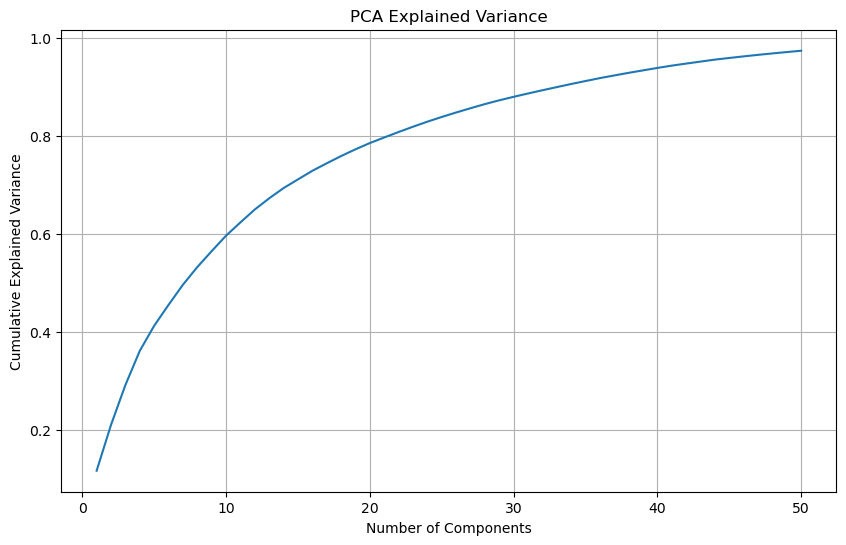

In [27]:
# 1. PCA Explained Variance
plt.figure(figsize=(10, 6))
cumsum = np.cumsum(best_pca.explained_variance_ratio_)
plt.plot(range(1, len(cumsum) + 1), cumsum)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

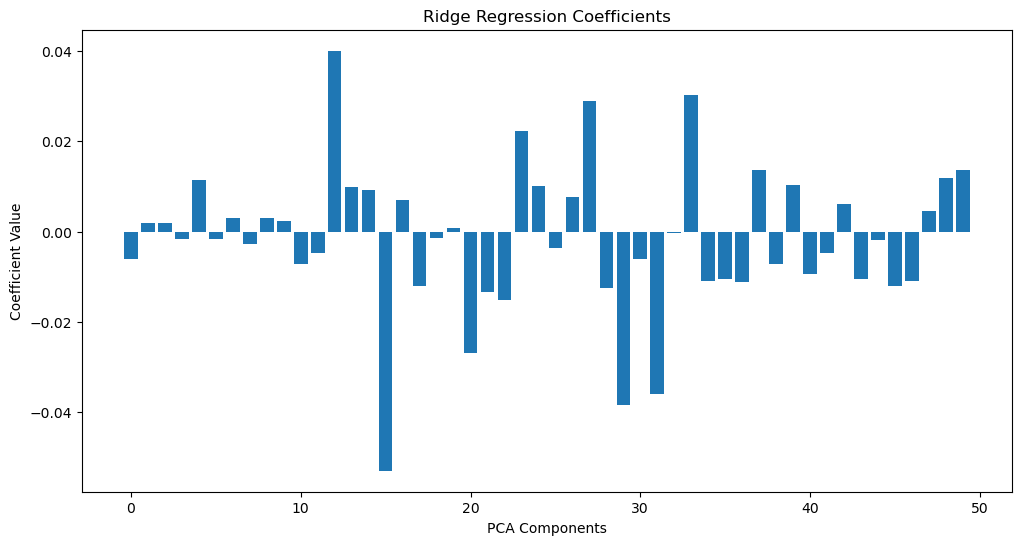

In [28]:
# 2. Ridge Regression Coefficients # 2million , >200.000  rows
plt.figure(figsize=(12, 6)) 
coef = best_ridge.coef_
plt.bar(range(len(coef)), coef)
plt.xlabel('PCA Components')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regression Coefficients')
plt.show()


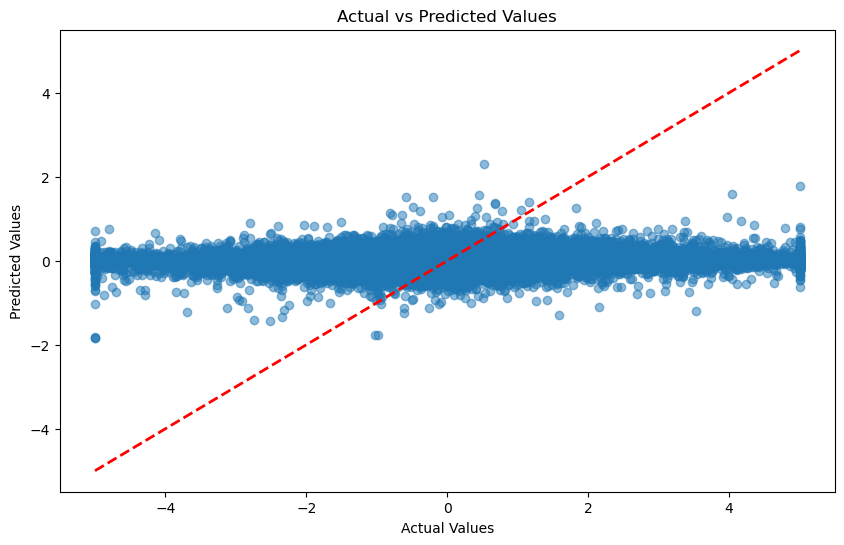

In [29]:
# 3. Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


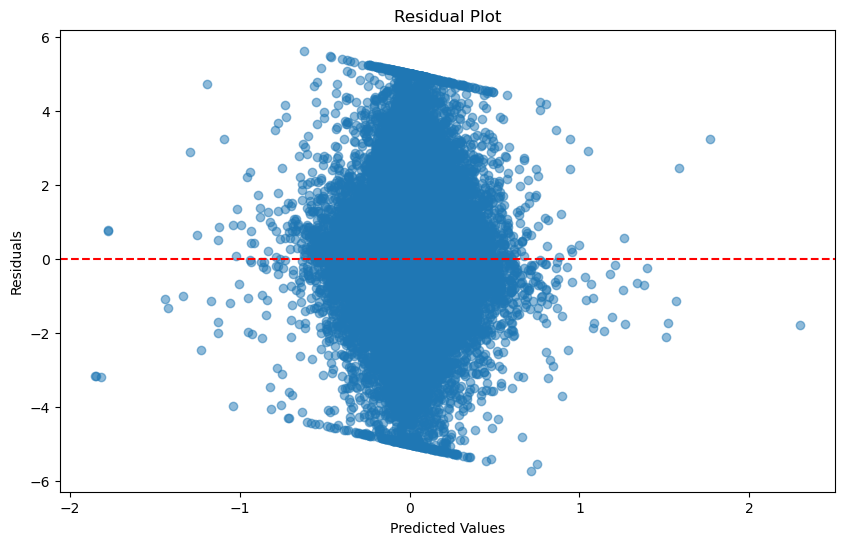

In [30]:
# 4. Residual Plot
residuals = y_test - y_pred_ridge
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_ridge, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

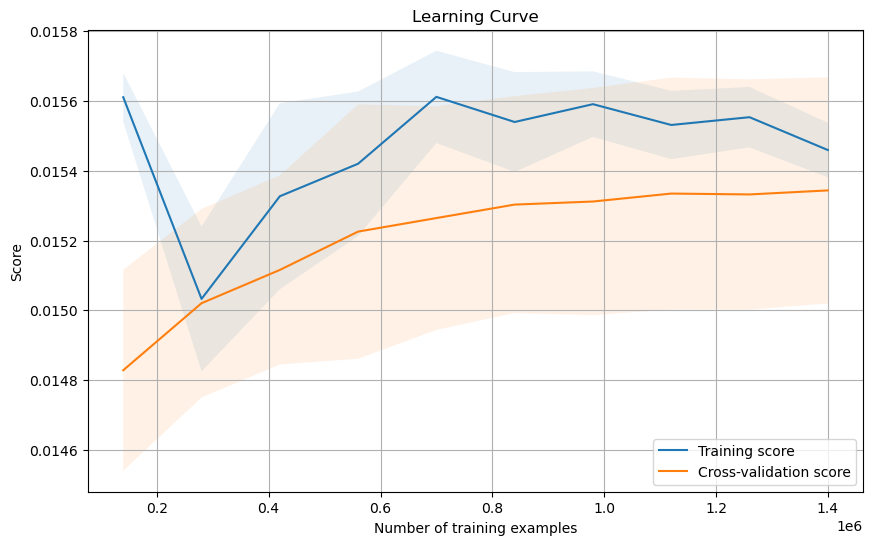

In [31]:
# 5. Learning Curve
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores = learning_curve(
    best_ridge, X_train_pca, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [32]:
import shap
import matplotlib.pyplot as plt

# Create SHAP explainer for Ridge
explainer = shap.Explainer(best_ridge, X_train_pca)

# Compute SHAP values
shap_values = explainer(X_test_pca)


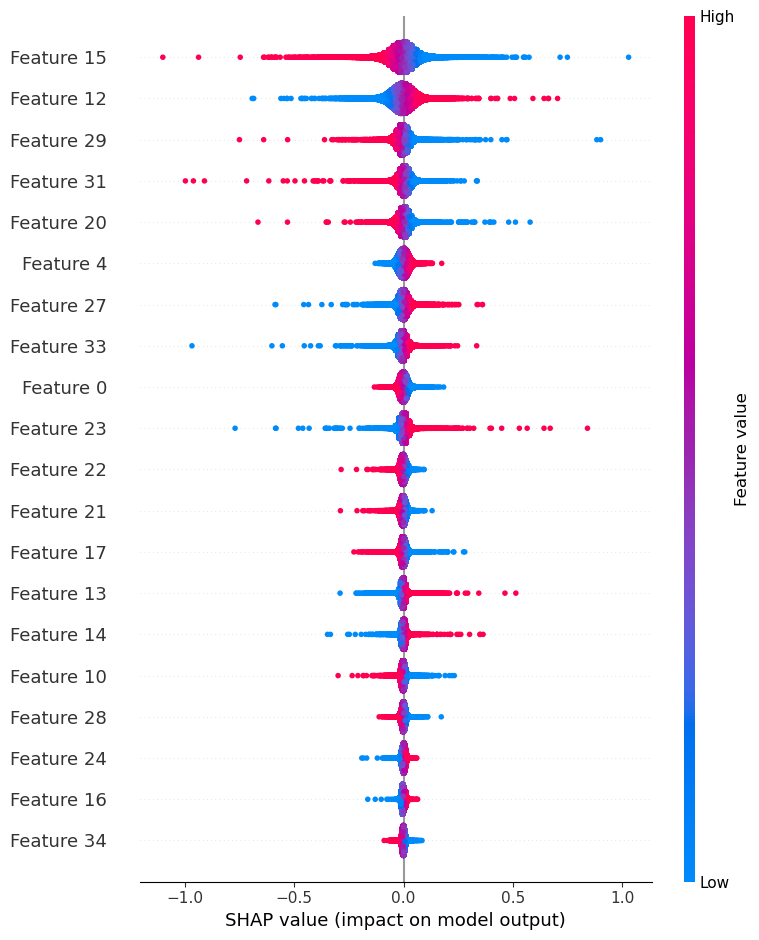

In [33]:
shap.summary_plot(shap_values, X_test_pca)


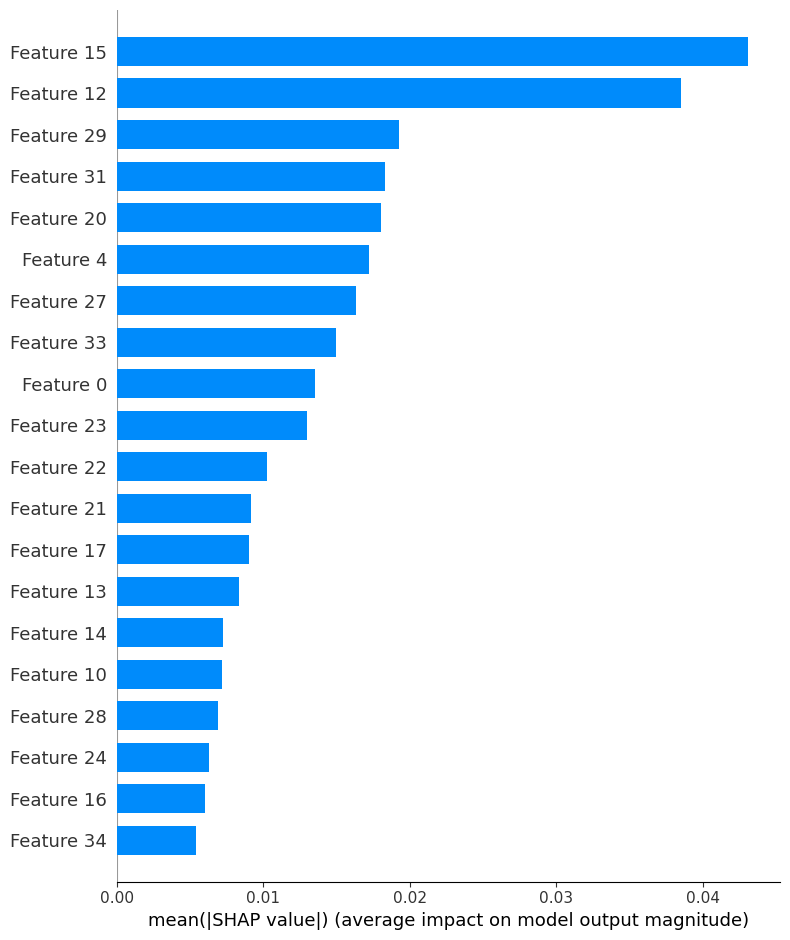

In [34]:
shap.summary_plot(shap_values, X_test_pca, plot_type="bar")


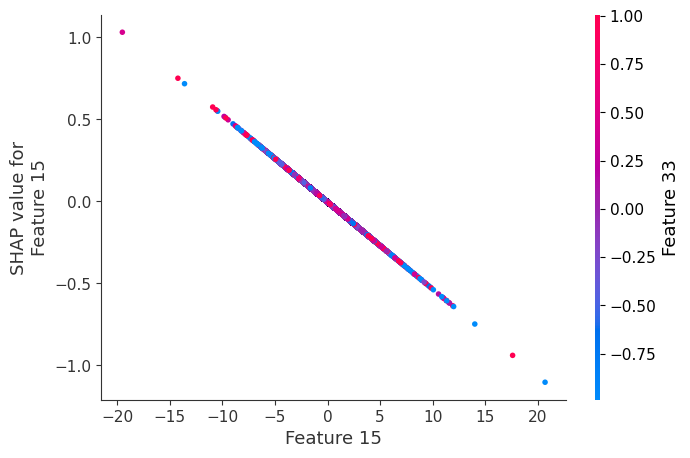

In [35]:
# Identify the most important feature based on SHAP values
important_feature = np.argmax(np.abs(shap_values.values).mean(axis=0))

# SHAP Dependence Plot for the most important feature
shap.dependence_plot(important_feature, shap_values.values, X_test_pca)
